In [ ]:
!pip install -q transformers trl datasets accelerate peft bitsandbytes

In [ ]:
import transformers
from transformers import AutoTokenizer , AutoModelForCausalLM , BitsAndBytesConfig
import torch
from datasets import Dataset , load_dataset
from peft import LoraConfig , prepare_model_for_kbit_training , AutoPeftModelForCausalLM , get_peft_model
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.float16)

In [ ]:
model_id = 'mistralai/Mistral-7B-Instruct-v0.2'
model = AutoModelForCausalLM.from_pretrained(model_id , quantization_config = bnb_config , device_map = "auto")
tokenizer = AutoTokenizer.from_pretrained(model_id ,padding_side = 'left' , add_bos_token = True ,  add_eos_token = True)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:

print(tokenizer)

LlamaTokenizerFast(name_or_path='mistralai/Mistral-7B-Instruct-v0.2', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [ ]:
data_path = "LinhDuong/chatdoctor-5k"
dataset = load_dataset(data_path , split = 'train')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset[0]

{'output': "Well, based on what you're telling me, it sounds like you may be suffering from panic disorder. The best course of action is to start with psychotherapy and mental health counseling. Additionally, we should conduct an electrocardiogram to make sure that there are no physical issues causing your panic attacks. We will also need to perform a depression screen and a toxicology screen to rule out any other underlying causes. Finally, I would recommend a comprehensive psychological and psychiatric evaluation and therapy to help manage your symptoms.",
 'input': "Doctor, I have been experiencing sudden and frequent panic attacks. I don't know what to do.",
 'instruction': "If you are a doctor, please answer the medical questions based on the patient's description."}

In [ ]:
def formatting_func(example):
    text = f"### Instruction: {example['instruction']} Question: {example['input']}\n ### Answer: {example['output']}"
    return text

In [ ]:
max_length = 512
def generate_and_tokenize_prompt(prompt):
    result = tokenizer(formatting_func(prompt),
                    truncation = True ,
                    padding = "max_length",
                    max_length = max_length)
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
dataset = dataset.train_test_split(test_size = 0.2)


In [ ]:
train_data = dataset["train"]
eval_data = dataset["test"]

In [ ]:
train_data = train_data.map(generate_and_tokenize_prompt)
eval_data = eval_data.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/4361 [00:00<?, ? examples/s]

Map:   0%|          | 0/1091 [00:00<?, ? examples/s]

5452


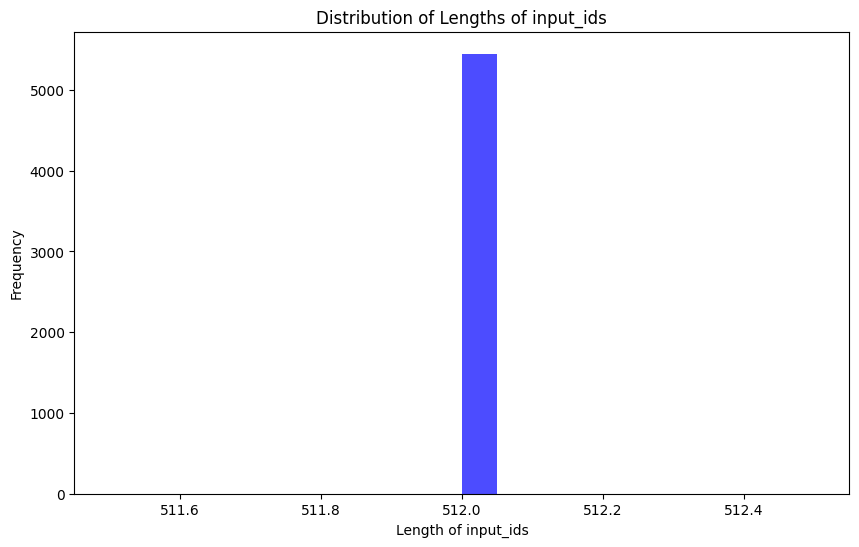

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(train_data, eval_data):
    lengths = [len(x['input_ids']) for x in train_data]
    lengths += [len(x['input_ids']) for x in eval_data]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(train_data, eval_data)

In [ ]:
eval_prompt = " Doctor, I have been experiencing sudden and frequent panic attacks. I don't know what to do."
model_input = tokenizer(eval_prompt, return_tensors="pt" ).to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Doctor, I have been experiencing sudden and frequent panic attacks. I don't know what to do.

I'm sorry to hear that you're going through this. Panic attacks can be very distressing and debilitating. Here are some steps you can take to help manage your symptoms:

1. Practice relaxation techniques: Deep breathing exercises, progressive muscle relaxation, or meditation can help calm your mind and body during a panic attack. Try practicing these techniques when you're feeling calm so that you can remember them during an attack.
2. Identify triggers: If there are specific situations or things that trigger your panic attacks, try to avoid them if possible. If avoiding the trigger isn't an option, prepare yourself by using relaxation techniques beforehand.
3. Seek support: Talking to a trusted friend or family member about your anxiety can be helpful. You may also consider seeking professional help from a therapist or counselor who specializes in anxiety disorders.
4. Stay informed: Educati

In [ ]:
torch.cuda.empty_cache()
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):

    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [ ]:
lora_config = LoraConfig(
r = 32,
lora_alpha = 64,
target_modules = ['q_proj' , 'k_proj' , 'v_proj' , 'o_proj' , 'gate_proj' , 'up_proj' , 'down_proj' , 'lm_head'],
bias = "none",
lora_dropout = 0.01,
task_type = "CAUSAL_LM")
model = get_peft_model(model , lora_config)

In [ ]:
print_trainable_parameters(model)

In [ ]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

In [ ]:
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "medgeinus"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=25,
        evaluation_strategy="steps",
        eval_steps=25,
        do_eval=True,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.451400,1.094468
50,1.047300,1.016323
75,1.036800,0.959948
100,0.989800,0.913298
125,0.889000,0.890241
150,0.906600,0.876652


/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

KeyboardInterrupt: 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/kaggle/working/mistral-medgeinus/checkpoint-125")

In [ ]:
ft_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

In [ ]:
eval_prompt = train_data[643]

In [ ]:
eval_prompt['instruction'] + eval_prompt['input']

"If you are a doctor, please answer the medical questions based on the patient's description.Doctor, I have been experiencing some unusual symptoms lately. My shoulder is swollen, I have been having seizures, and my lips are swollen. Additionally, I have been biting my nails more often, and I am experiencing some hip stiffness or tightness."

In [ ]:
eval_prompt = "Doctor, I have been having some trouble lately with my sleeping patterns. I often feel tired during the day, and even though I try to get enough sleep at night. ### Answer:"

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Doctor, I have been having some trouble lately with my sleeping patterns. I often feel tired during the day, and even though I try to get enough sleep at night. ### Answer:
 ### 1. The patient is suffering from a condition called insomnia. It is a common problem that affects many people in their daily lives.
### 2. Insomnia can be caused by various factors such as stress, anxiety, depression or other medical conditions like heart disease or high blood pressure.
### 3. To treat this condition effectively it's important for patients to understand what causes their symptoms so they can take steps towards managing them better over time.
###


In [ ]:
notebook_login()

In [ ]:
trainer.push_to_hub()

/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/865M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sidmanale643/mistral-medgeinus/commit/739eec606ac7d69e146153dcecb7890f87efc9ac', commit_message='End of training', commit_description='', oid='739eec606ac7d69e146153dcecb7890f87efc9ac', pr_url=None, pr_revision=None, pr_num=None)